# Sudoku Solver using a Genetic Algorithm
---
## Problem Description
Sudoku is a classic logic-based number-placement puzzle. The objective is to fill a 9x9 grid with digits so that each column, each row, and each of the nine 3x3 subgrids (also called "blocks" or "boxes") contains all of the digits from 1 to 9. For a well-posed puzzle, the puzzle setter provides a partially completed grid that has a single, unique solution.

This notebook implements a Sudoku solver using a **Genetic Algorithm (GA)**. Genetic algorithms are a class of optimization algorithms inspired by natural selection. They are used to find approximate solutions to optimization and search problems.

**How it applies to Sudoku:**
1.  **Individuals (Solutions):** Each "individual" in our population represents a potential solution to the Sudoku puzzle (a filled 9x9 grid).
2.  **Fitness Function:** We define a fitness function that evaluates how "good" a solution is. A higher fitness score indicates fewer violations of Sudoku rules (i.e., fewer duplicate numbers in rows, columns, and 3x3 blocks). The goal is to maximize this fitness score.
3.  **Population:** We start with a population of randomly generated Sudoku grids.
4.  **Selection:** Better-performing individuals (those with higher fitness) are more likely to be selected to "reproduce."
5.  **Crossover (Reproduction):** Selected individuals (parents) combine their "genetic material" (parts of their grids) to create new individuals (children).
6.  **Mutation:** Random changes are introduced into the children to maintain genetic diversity and prevent premature convergence to suboptimal solutions.
7.  **Evolution:** The process of selection, crossover, and mutation repeats over many generations. Over time, the population's average fitness should increase, leading to individuals closer to a valid Sudoku solution.

The algorithm aims to find a grid where the fitness score reaches the maximum possible value. For a 9x9 Sudoku, this maximum is 243, representing 9 correct numbers in each of 9 rows + 9 columns + 9 blocks (27 sets, each contributing 9 points for uniqueness). If a solution with maximum fitness is found, it indicates a valid Sudoku solution.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import numpy as np
from IPython.display import clear_output
import uuid
%matplotlib inline

In [2]:
# General configuration
GRID_SIZE = 9
CELL_SIZE = 50


In [10]:
class SudokuGeneticAlgorithm():
    def __init__(self,
                 pop_size=100,
                 max_generations=1000,
                 mutation_rate=0.05,
                 sudoku_puzzle=[]):
        """
        Initializes the SudokuGeneticAlgorithm with a set of parameters for the genetic process.

        Args:
            pop_size (int): The total number of candidate solutions (individuals) in each generation.
            max_generations (int): The maximum number of evolutionary cycles the algorithm will run.
            mutation_rate (float): The probability that a gene (cell value) in an individual will randomly change.
            sudoku_puzzle (list of lists): The initial Sudoku puzzle grid, where 0s represent empty cells.
        """

        self.pop_size = pop_size
        self.max_generations = max_generations
        self.mutation_rate = mutation_rate
        # Convert the input puzzle to a NumPy array for efficient operations.
        self.sudoku_puzzle = np.array(sudoku_puzzle) 
        # Stores the highest fitness score achieved so far.
        self.best_fitness = 0
        # Identifies and stores the coordinates of the pre-filled, unchangeable cells in the puzzle.
        self.fixed_positions = {(r, c) for r in range(GRID_SIZE) for c in range(GRID_SIZE) if self.sudoku_puzzle[r][c] != 0}
        self.history_best = set() # A set to keep track of the hash IDs of the best solutions found across generations to avoid revisiting identical solutions.

    def draw_grid(self, grid, generation, fitness_score):
        """
        Visually renders the Sudoku grid, including generation and fitness information.

        Args:
            grid (np.array): The 9x9 NumPy array representing the Sudoku grid to be displayed.
            generation (int): The current generation number of the genetic algorithm.
            fitness_score (int): The fitness score of the displayed grid, indicating its proximity to a solution.
        """
        clear_output(wait=True) 
        plt.figure(figsize=(8, 8)) 
        plt.title(f"Generación: {generation} - Fitness: {fitness_score}", fontsize=14) 
        plt.gca().set_facecolor((0.8, 0.8, 0.8)) 

        # Draws the Sudoku grid lines, with thicker lines for the 3x3 blocks.
        for r in range(GRID_SIZE + 1):
            lw = 2 if r % 3 == 0 else 0.5 
            plt.plot([0, GRID_SIZE], [r, r], 'k', linewidth=lw) 
            plt.plot([r, r], [0, GRID_SIZE], 'k', linewidth=lw) 

        # Adds the numbers to the grid, distinguishing between fixed and evolved numbers.
        for r in range(GRID_SIZE):
            for c in range(GRID_SIZE):
                if grid[r][c] != 0: 
                    # Sets the color of the number: dark red for fixed, dark blue for evolved.
                    color = 'darkred' if (r, c) in self.fixed_positions else 'darkblue'
                    plt.text(c + 0.5, GRID_SIZE - r - 0.5, str(grid[r][c]), 
                             ha='center', va='center', fontsize=14, color=color, fontweight='bold')

        plt.xticks([]) 
        plt.yticks([]) 
        plt.show() 
        plt.close() 

    def _generate_population_blocks(self, total_pop):
        """
        Generates the initial population of Sudoku grids, prioritizing the correct filling of 3x3 blocks.
        This approach aims to start with individuals that are already partially valid.

        Args:
            total_pop (int): The desired number of individuals to generate for the initial population.

        Returns:
            list: A list of NumPy arrays, each representing a Sudoku grid (an individual in the population).
        """
        population = []

        for _ in range(total_pop):
            individual = np.copy(self.sudoku_puzzle) # Starts building an individual from a copy of the original puzzle.

            # Iterates through each of the nine 3x3 blocks.
            for block_row in range(3):
                for block_col in range(3):
                    r_start, c_start = block_row * 3, block_col * 3 # Calculates the starting row and column for the current block.

                    # Collects all (row, column) coordinates within the current 3x3 block.
                    block_coords = [
                        (r, c)
                        for r in range(r_start, r_start + 3)
                        for c in range(c_start, c_start + 3)
                    ]

                    fixed_vals = set() 
                    non_fixed_coords = []

                    # Populates fixed_vals and non_fixed_coords based on the puzzle's initial state.
                    for r, c in block_coords:
                        val = individual[r][c]
                        if (r, c) in self.fixed_positions:
                            fixed_vals.add(val)
                        else:
                            non_fixed_coords.append((r, c))

                    # Determines which numbers (1-9) are available to be placed in the current block, excluding fixed values.
                    available = list(set(range(1, 10)) - fixed_vals)
                    np.random.shuffle(available) # Shuffles the available numbers to ensure randomness in placement.

                    # Fills the non-fixed cells within the block.
                    for r, c in non_fixed_coords:
                        placed = False
                        # Attempts to place an available value that does not conflict with its current row or column.
                        for val in available:
                            if val not in individual[r, :] and val not in individual[:, c]:
                                individual[r][c] = val
                                # Removes the placed value from the available list for this block.
                                available.remove(val) 
                                placed = True
                                break

                        if not placed and available:
                            # If no conflict-free placement is immediately found, places any remaining available number.
                            individual[r][c] = available.pop()
                        elif not placed:
                            # As a fallback, if no numbers are available (shouldn't happen if `available` is properly managed), places a random number.
                            individual[r][c] = np.random.randint(1, 10)

            population.append(individual) # Adds the newly created individual to the population.

        return population

    def _generate_population(self, total_pop, rand=False):
        """
        (Alternative population generation method) Generates a population by filling cells, prioritizing fixed positions.
        This method is currently not used in the `start_genetic_algorithm` function but remains available.

        Args:
            total_pop (int): The desired number of individuals for the population.
            rand (bool): If True, allows for truly random assignments when no other options are available.

        Returns:
            list: A list of NumPy arrays, each representing a Sudoku grid.
        """
        population = []
        for _ in range(total_pop):
            current_sudoku_board = np.zeros((9, 9), dtype=int) 
            for r in range(9):
                available_numbers_row = list(range(1, 9)) 
                for c in range(9):
                    if (r, c) in self.fixed_positions:
                        fixed_value = self.sudoku_puzzle[r][c]
                        current_sudoku_board[r][c] = fixed_value
                        if fixed_value in available_numbers_row:
                            available_numbers_row.remove(fixed_value) 
                    else:
                        # Numbers already in the current column.
                        available_numbers_col = set([num for num in current_sudoku_board[:,c] if num!=0]) 
                        # Numbers available for this cell considering row and column.
                        total_available = list(set(available_numbers_row) - available_numbers_col) 

                        if len(total_available) > 0:
                            current_sudoku_board[r][c] = np.random.choice(total_available, 1) # Chooses a random available number.
                        elif rand:
                            current_sudoku_board[r][c] = int(np.random.choice(range(1, 9))) # Random choice if no conflict-free options.
                        else:
                            # Leaves the cell empty if no valid number can be placed.
                            current_sudoku_board[r][c] = 0 

            population.append(np.array(current_sudoku_board))
        return population

    def _compute_fitness(self, grid):
        """
        Calculates the fitness score of a given Sudoku grid. A higher score indicates fewer rule violations.
        The maximum possible fitness for a 9x9 grid is 243 (9 points for each of 9 rows, 9 columns, and 9 blocks).

        Args:
            grid (np.array): The Sudoku grid for which to calculate the fitness.

        Returns:
            int: The calculated fitness score.
        """
        penalty = 0

        # Penalizes duplicate values within each row.
        # The penalty is weighted by the number of fixed values in that row,
        # giving more importance to correctly placing numbers around fixed ones.
        for i in range(GRID_SIZE):
            row = grid[i, :]
            penalty += (GRID_SIZE - len(set(row))) * (sum([1 for t in self.fixed_positions if t[0] == i]))

        # Penalizes duplicate values within each column, similarly weighted by fixed positions.
        for i in range(GRID_SIZE):
            col = grid[:, i]
            penalty += (GRID_SIZE - len(set(col))) * (sum([1 for t in self.fixed_positions if t[1] == i]))

        # Penalizes duplicate values within each 3x3 block.
        for i in range(3):
            for j in range(3):
                # Extracts and flattens the 3x3 block.
                block = grid[i*3:(i+1)*3, j*3:(j+1)*3].flatten() 
                # Adds penalty based on unique numbers in the block.
                penalty += GRID_SIZE - len(set(block)) 

        
        # Subtracts the total penalty from the maximum possible fitness.
        total_fitness = 243 - penalty 
        return total_fitness

    def _crossover_row(self, p1, p2, probability=0.5):
        """
        (Alternative crossover method) Performs crossover by swapping entire rows between two parent grids.
        This method is currently not used in the `start_genetic_algorithm` function but remains available.

        Args:
            p1 (np.array): The first parent grid.
            p2 (np.array): The second parent grid.
            probability (float): The probability of swapping a row.

        Returns:
            np.array: The child grid resulting from the row-based crossover.
        """
        mask = np.random.rand(9) < probability # Creates a boolean mask to decide which rows to swap.
        child = np.where(mask[:, None], p1, p2) # Creates the child grid by selecting rows from p1 or p2 based on the mask.
        return child

    def _crossover_blocks(self, p1, p2):
        """
        Performs crossover between two parent grids by randomly swapping 3x3 blocks.
        This method helps in combining good block structures from different parents.

        Args:
            p1 (np.array): The first parent grid.
            p2 (np.array): The second parent grid.

        Returns:
            np.array: The child grid generated from the block-based crossover.
        """
        child = np.copy(p1) # The child initially inherits all values from parent 1.

        for i in range(3):
            for j in range(3):
                if np.random.rand() < 0.5: # 50% chance for each 3x3 block to be inherited from parent 2.
                    # Copies the block from parent 2 to the child, ensuring fixed positions are not altered.
                    for r in range(i*3, (i+1)*3):
                        for c in range(j*3, (j+1)*3):
                            if (r, c) not in self.fixed_positions: # Only modify non-fixed cells.
                                child[r, c] = p2[r, c]
        return child

    def _mutate_simple(self, grid):
        """
        (Alternative mutation method) Performs a simple mutation by randomly changing cell values
        based on the mutation rate, avoiding fixed positions.
        This method is currently not used in the `start_genetic_algorithm` function but remains available.

        Args:
            grid (np.array): The grid to be mutated.

        Returns:
            np.array: The mutated grid.
        """
        mutation_mask = np.random.rand(*grid.shape) < self.mutation_rate # Creates a boolean mask for cells to mutate.
        random_values = np.random.randint(1, 10, grid.shape) # Generates random new values for potential mutations.

        mutated_grid = np.copy(grid) # Creates a copy of the grid to apply mutations.

        for r in range(9):
            for c in range(9):
                # If a cell is marked for mutation and is not a fixed position, its value is changed.
                if mutation_mask[r][c] and (r, c) not in self.fixed_positions:
                    mutated_grid[r][c] = random_values[r][c]
        return mutated_grid

    def _mutate2(self, grid, max_attempts=5):
        """
        Performs a more refined mutation by swapping two non-fixed cells within a randomly chosen 3x3 block.
        This type of mutation tends to preserve block validity while introducing diversity. It also has a
        mechanism to prefer mutations that improve fitness.

        Args:
            grid (np.array): The grid to be mutated.
            max_attempts (int): The maximum number of attempts to find suitable cells for swapping.

        Returns:
            np.array: The mutated grid.
        """
        mutated = np.copy(grid) # Creates a working copy of the grid for mutation.

        for _ in range(max_attempts):
            # Selects a random 3x3 block.
            block_row = np.random.randint(0, 3)
            block_col = np.random.randint(0, 3)
            r_start, c_start = block_row * 3, block_col * 3

            # Collects the coordinates of non-fixed cells within the selected block.
            block_coords = [
                (r, c)
                for r in range(r_start, r_start + 3)
                for c in range(c_start, c_start + 3)
                if (r, c) not in self.fixed_positions
            ]

            if len(block_coords) < 2:
                continue # Skips if there aren't at least two non-fixed cells to swap.

            # Randomly selects two non-fixed cells within the block for swapping.
            (r1, c1), (r2, c2) = random.sample(block_coords, 2)
            mutated[r1, c1], mutated[r2, c2] = mutated[r2, c2], mutated[r1, c1] # Performs the swap.

            # Evaluates the fitness of the mutated grid.
            old_fitness = self._compute_fitness(grid)
            new_fitness = self._compute_fitness(mutated)

            # Decision to keep the mutation:
            # - If the new fitness is greater than or equal to the old fitness, the mutation is kept.
            # - Otherwise, there's a 50% chance (np.random.rand() < 0.5) to keep it anyway to encourage exploration.
            if new_fitness >= old_fitness or np.random.rand() < 0.5:
                break # Mutation accepted, exit loop.
            else:
                # Reverts the swap if the mutation was not beneficial and failed the random acceptance check.
                mutated[r1, c1], mutated[r2, c2] = mutated[r2, c2], mutated[r1, c1]

        return mutated

    def _display_progress(self, generation, best_solution, current_fitness, avg_fitness, draw=False):
        """
        Outputs the current progress of the genetic algorithm to the console and optionally draws the best solution.

        Args:
            generation (int): The current generation number.
            best_solution (np.array): The Sudoku grid representing the best individual in the current population.
            current_fitness (int): The fitness score of the best solution.
            avg_fitness (float): The average fitness score of all individuals in the current population.
            draw (bool): If True, the `draw_grid` method will be called to visualize the best solution.
        """
        print(f"Generation: {generation:4d} | Fitness: {current_fitness:3d} | Avg fitness {avg_fitness:.2f} | Max possible: 243")
        if draw:
            self.draw_grid(best_solution, generation, current_fitness)

    def _check_sequence(self, sequence):
        """
        Checks if a given sequence of numbers (representing a row, column, or 3x3 block) is valid
        according to Sudoku rules (i.e., contains unique numbers from 1 to 9).

        Args:
            sequence (list or np.array): A 1D sequence of numbers.

        Returns:
            bool: True if the sequence is valid, False otherwise.
        """
        seen = set() # Uses a set to efficiently check for duplicates.
        for num in sequence:
            if not (1 <= num <= 9):
                return False # Returns False if any number is outside the 1-9 range.
            if num in seen:
                return False # Returns False if a duplicate number is found.
            seen.add(num) # Adds the number to the set of seen numbers.
        return True # Returns True if all numbers are unique and within range.

    def is_sudoku_valid(self, board):
        """
        Performs a comprehensive check to determine if the entire Sudoku board is a valid solution.
        It verifies all rows, columns, and 3x3 blocks for compliance with Sudoku rules.

        Args:
            board (np.array): The 9x9 Sudoku board to validate.

        Returns:
            bool: True if the board is a perfectly valid Sudoku solution, False otherwise.
        """

        # Verifies all rows.
        for r in range(GRID_SIZE):
            if not self._check_sequence(board[r, :]):
                print(f"There is a problem in row: {r+1}")
                return False

        # Verifies all columns.
        for c in range(GRID_SIZE):
            if not self._check_sequence(board[:, c]):
                print(f"There is a problem in column: {c+1}")
                return False

        # Verifies all 3x3 blocks.
        for block_row in range(3):
            for block_col in range(3):
                start_row = block_row * 3
                start_col = block_col * 3

                block = board[start_row:start_row + 3, start_col:start_col + 3].flatten() # Extracts and flattens the block.
                if not self._check_sequence(block):
                    print(f"There is a problem in block at row {block_row*3}-{block_row*3+2}, col {block_col*3}-{block_col*3+2}")
                    return False

        return True # Returns True if all checks pass, indicating a valid Sudoku solution.

    def _local_improvement(self, individual):
        """
        Attempts to locally improve an individual (Sudoku grid) by identifying and resolving
        duplicate numbers within 3x3 blocks and then filling empty cells. This method is part
        of a local search heuristic often combined with genetic algorithms.

        Args:
            individual (np.array): The Sudoku grid to be improved.

        Returns:
            np.array: The locally improved Sudoku grid.
        """
        improved = np.copy(individual) # Creates a working copy of the individual.

        for block_row in range(3):
            for block_col in range(3):
                r_start, c_start = block_row * 3, block_col * 3

                # Collects all coordinates within the current 3x3 block.
                block_coords = [
                    (r, c)
                    for r in range(r_start, r_start + 3)
                    for c in range(c_start, c_start + 3)
                ]

                fixed_vals = set() # Stores values from fixed positions within this block.
                non_fixed_coords = [] # Stores coordinates of non-fixed cells.
                block_vals = [] # Stores all values currently in the block.

                # Populates the lists and sets.
                for r, c in block_coords:
                    val = improved[r, c]
                    block_vals.append(val)
                    if (r, c) in self.fixed_positions:
                        fixed_vals.add(val)
                    else:
                        non_fixed_coords.append((r, c))

                # Counts the occurrences of each value in the block.
                val_counts = {}
                for val in block_vals:
                    if val != 0:
                        val_counts[val] = val_counts.get(val, 0) + 1

                # Identifies duplicate values among non-fixed cells.
                duplicates = {val for val, count in val_counts.items() if count > 1 and val not in fixed_vals}

                # Resets duplicate non-fixed cells to 0 and tracks seen values to avoid marking non-duplicates as such.
                seen = set()
                for r, c in non_fixed_coords:
                    val = improved[r, c]
                    if val in seen or val in duplicates:
                        improved[r, c] = 0 # Sets the duplicate cell to 0 (empty).
                    else:
                        seen.add(val)

                # Identifies empty cells and missing numbers (1-9) in the block.
                empty_cells = [(r, c) for r, c in block_coords if improved[r, c] == 0]
                missing = list(set(range(1, 10)) - {improved[r, c] for r, c in block_coords})

                # Fills the empty cells with missing numbers, prioritizing placements that minimize conflicts
                # with existing numbers in their respective rows and columns.
                for val in missing:
                    best_cell = None
                    min_conflicts = float('inf') # Initializes with a very high conflict count.

                    for r, c in empty_cells:
                        # Calculates conflicts in the row and column for the potential placement.
                        row_conflict = np.count_nonzero(improved[r, :] == val)
                        col_conflict = np.count_nonzero(improved[:, c] == val)
                        total_conflict = row_conflict + col_conflict

                        if total_conflict < min_conflicts:
                            min_conflicts = total_conflict
                            best_cell = (r, c)

                    if best_cell:
                        improved[best_cell] = val # Places the value in the cell with the fewest conflicts.
                        empty_cells.remove(best_cell) # Removes the filled cell from the list of empty cells.

        return improved

    def create_individual(self, grid):
        """
        Generates a unique hash identifier for a Sudoku grid based on its string representation.
        This is used to detect and remove duplicate individuals in the population.

        Args:
            grid (np.array): The Sudoku grid (individual).

        Returns:
            UUID: A UUID (Universally Unique Identifier) object representing the grid's state.
        """
        return uuid.uuid5(uuid.NAMESPACE_DNS, str(grid))

    def remove_duplicates(self, population):
        """
        Filters out duplicate individuals from a given population list.

        Args:
            population (list): A list of Sudoku grids (individuals).

        Returns:
            list: A new list containing only unique Sudoku grids.
        """
        seen = set() # A set to store hash IDs of individuals already added to the unique list.
        unique_population = []

        for individual in population:
            hash_id = self.create_individual(individual) # Generates a hash ID for the current individual.
            if hash_id not in seen:
                seen.add(hash_id) # Adds the hash ID to the seen set.
                unique_population.append(individual) # Adds the individual to the unique list.

        return unique_population

    def start_genetic_algorithm(self):
        """
        The main loop of the genetic algorithm, orchestrating the evolution of Sudoku solutions.
        It manages population generation, fitness evaluation, selection, crossover, and mutation
        over a specified number of generations until a solution is found or the maximum generations are reached.
        """
        # Initializes the population using a block-filling strategy.
        population = self._generate_population_blocks(self.pop_size)
        no_improve_count = 0 # Tracks generations without improvement in the best fitness.
        best_fitness = 0 # Stores the best fitness achieved across all generations.
        self.history_best = set() # Stores hash IDs of all historical best solutions.

        for generation in range(self.max_generations):
            # Sorts the population in descending order based on their fitness scores.
            population.sort(key=lambda x: - self._compute_fitness(x))
            best_solution = population[0] # The best solution is the first individual after sorting.
            current_fitness = self._compute_fitness(best_solution) # Fitness of the current best solution.
            fitness_scores = [self._compute_fitness(ind) for ind in population]
            avg_fitness = sum(fitness_scores) / len(fitness_scores) # Calculates the average fitness of the population.
            self.history_best.add(str(self.create_individual(best_solution))) # Adds the hash of the current best solution to history.

            # Checks for stagnation (no improvement in best fitness over several generations).
            if current_fitness <= best_fitness:
                no_improve_count += 1
            else:
                best_fitness = current_fitness
                no_improve_count = 0 # Resets counter if improvement is observed.

            # If stagnation is detected, adjust parameters to encourage diversity and exploration.
            if no_improve_count >= 5:
                # This block aims to introduce new diversity or escape local optima.
                # It increases the mutation rate to promote more drastic changes.
                self.mutation_rate += 0.001
                no_improve_count = 0

                # Attempts to pick a new 'best_solution' from the current population that hasn't been a historical best,
                # to try a different evolutionary path.
                found_new_best_candidate = False
                for i in population[1:]: # Iterates through solutions other than the absolute current best.
                    if str(self.create_individual(i)) not in self.history_best:
                        best_solution = i # Selects this as a new starting point for the next generation.
                        found_new_best_candidate = True
                        break
                # If all other solutions in the current population have already been 'historical bests',
                # removing the current best from the population can force the algorithm to explore new states.
                if not found_new_best_candidate and population:
                    population.pop(0) # Removes the very best, forcing reliance on other individuals.

            print("BEST: ", str(self.create_individual(best_solution))) # Debug print of the best solution's ID.

            # Displays the algorithm's progress for the current generation.
            self._display_progress(
                generation,
                best_solution,
                current_fitness,
                avg_fitness
            )

            # Checks if the perfect solution has been found.
            if current_fitness == 243:
                print("\nSudoku solved!")
                self.is_sudoku_valid(best_solution) # Final validation of the solution.
                self.draw_grid(best_solution, generation, current_fitness) # Draws the final solved grid.
                return best_solution # Returns the solved Sudoku grid.

            # Prepares for the next generation: Selection.
            # Selects the top 50% of the population as parents for reproduction.
            parents = population[:int(self.pop_size * 0.50)]

            # Elite preservation: Ensures a small percentage of the very best individuals
            # from the current generation directly pass to the next generation without modification,
            # preserving good traits.
            elite_count = int(0.05 * self.pop_size)
            elite = []
            for e in population[:elite_count]:
                # Applies a local improvement heuristic to elite individuals. This can
                # potentially fine-tune them before passing to the next generation.
                elite.append(self._local_improvement(e))

            # Creates the new population for the next generation.
            # It starts with a copy of the overall best solution found and the elite individuals.
            new_pop = [best_solution.copy()] + elite

            # Fills the rest of the new population through crossover and mutation.
            while len(new_pop) < self.pop_size:
                p1, p2 = random.choices(parents, k=2) # Randomly selects two parents from the parent pool.
                child = self._mutate2(self._crossover_blocks(p1, p2)) # Creates a child using block-based crossover and then mutates it.
                new_pop.append(child) # Adds the new child to the population.

            # Removes any duplicate individuals from the newly created population to maintain diversity.
            population = self.remove_duplicates(new_pop)


        # If the maximum number of generations is reached without finding a perfect solution.
        print("\nSolution not found within maximum generations.")
        # Displays the best solution found at the end of the run.
        self._display_progress(
            generation,
            best_solution,
            current_fitness,
            avg_fitness,
            True # Draws the final best grid.
        )

        # Performs a final validation check on the best solution found, even if not perfect.
        if self.is_sudoku_valid(best_solution):
            print("The best solution found is a valid Sudoku (might not be perfectly solved if fitness < 243).")
        else:
            print("The best solution found is not a perfectly valid Sudoku.")

        return best_solution # Returns the best solution found.

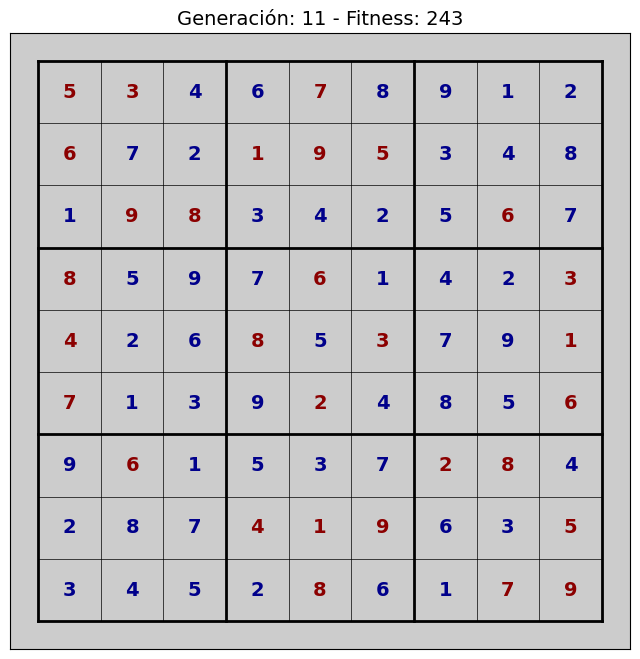

array([[5, 3, 4, 6, 7, 8, 9, 1, 2],
       [6, 7, 2, 1, 9, 5, 3, 4, 8],
       [1, 9, 8, 3, 4, 2, 5, 6, 7],
       [8, 5, 9, 7, 6, 1, 4, 2, 3],
       [4, 2, 6, 8, 5, 3, 7, 9, 1],
       [7, 1, 3, 9, 2, 4, 8, 5, 6],
       [9, 6, 1, 5, 3, 7, 2, 8, 4],
       [2, 8, 7, 4, 1, 9, 6, 3, 5],
       [3, 4, 5, 2, 8, 6, 1, 7, 9]])

In [11]:
sudoku_puzzle = [
    [5, 3, 0, 0, 7, 0, 0, 0, 0],
    [6, 0, 0, 1, 9, 5, 0, 0, 0],
    [0, 9, 8, 0, 0, 0, 0, 6, 0],
    [8, 0, 0, 0, 6, 0, 0, 0, 3],
    [4, 0, 0, 8, 0, 3, 0, 0, 1],
    [7, 0, 0, 0, 2, 0, 0, 0, 6],
    [0, 6, 0, 0, 0, 0, 2, 8, 0],
    [0, 0, 0, 4, 1, 9, 0, 0, 5],
    [0, 0, 0, 0, 8, 0, 0, 7, 9]
]

genetic = SudokuGeneticAlgorithm(
    pop_size=500, 
    max_generations=1000,
    mutation_rate=0.01,
    sudoku_puzzle=sudoku_puzzle
)

genetic.start_genetic_algorithm()

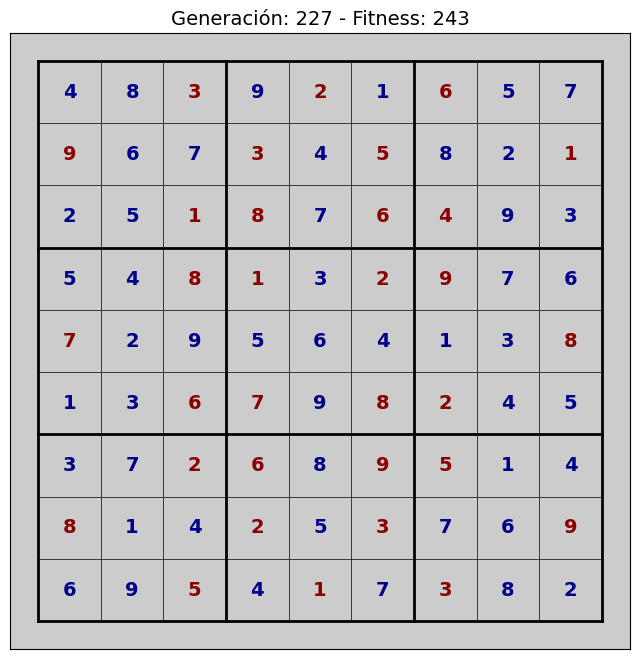

array([[4, 8, 3, 9, 2, 1, 6, 5, 7],
       [9, 6, 7, 3, 4, 5, 8, 2, 1],
       [2, 5, 1, 8, 7, 6, 4, 9, 3],
       [5, 4, 8, 1, 3, 2, 9, 7, 6],
       [7, 2, 9, 5, 6, 4, 1, 3, 8],
       [1, 3, 6, 7, 9, 8, 2, 4, 5],
       [3, 7, 2, 6, 8, 9, 5, 1, 4],
       [8, 1, 4, 2, 5, 3, 7, 6, 9],
       [6, 9, 5, 4, 1, 7, 3, 8, 2]])

In [12]:
# Tamaño del tablero
GRID_SIZE = 9
CELL_SIZE = 50

sudoku1 = [
    [0, 0, 3, 0, 2, 0, 6, 0, 0],
    [9, 0, 0, 3, 0, 5, 0, 0, 1],
    [0, 0, 1, 8, 0, 6, 4, 0, 0],
    [0, 0, 8, 1, 0, 2, 9, 0, 0],
    [7, 0, 0, 0, 0, 0, 0, 0, 8],
    [0, 0, 6, 7, 0, 8, 2, 0, 0],
    [0, 0, 2, 6, 0, 9, 5, 0, 0],
    [8, 0, 0, 2, 0, 3, 0, 0, 9],
    [0, 0, 5, 0, 1, 0, 3, 0, 0]
]

genetic = SudokuGeneticAlgorithm(
    pop_size=500, 
    max_generations=1000,
    mutation_rate=0.01,
    sudoku_puzzle=sudoku1
)

genetic.start_genetic_algorithm()

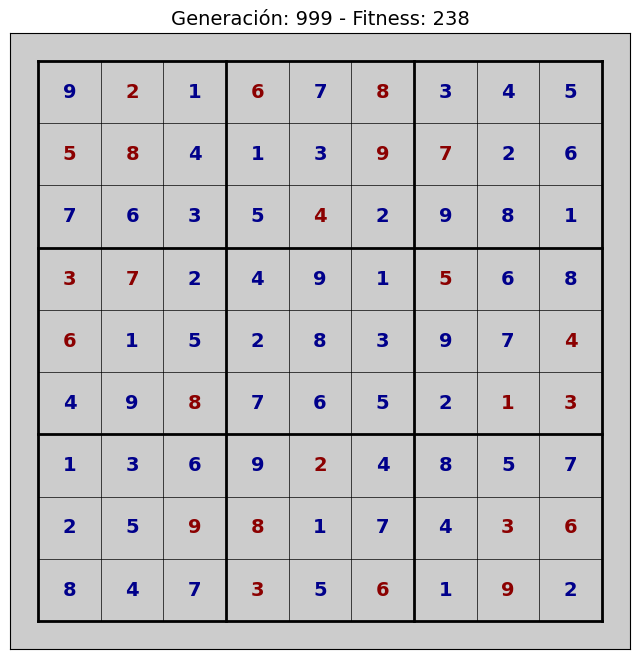

There is a problem in column: 7
The best solution found is not a perfectly valid Sudoku.


array([[9, 2, 1, 6, 7, 8, 3, 4, 5],
       [5, 8, 4, 1, 3, 9, 7, 2, 6],
       [7, 6, 3, 5, 4, 2, 9, 8, 1],
       [3, 7, 2, 4, 9, 1, 5, 6, 8],
       [6, 1, 5, 2, 8, 3, 9, 7, 4],
       [4, 9, 8, 7, 6, 5, 2, 1, 3],
       [1, 3, 6, 9, 2, 4, 8, 5, 7],
       [2, 5, 9, 8, 1, 7, 4, 3, 6],
       [8, 4, 7, 3, 5, 6, 1, 9, 2]])

In [13]:
sudoku2= [
    [0, 2, 0, 6, 0, 8, 0, 0, 0],
    [5, 8, 0, 0, 0, 9, 7, 0, 0],
    [0, 0, 0, 0, 4, 0, 0, 0, 0],
    [3, 7, 0, 0, 0, 0, 5, 0, 0],
    [6, 0, 0, 0, 0, 0, 0, 0, 4],
    [0, 0, 8, 0, 0, 0, 0, 1, 3],
    [0, 0, 0, 0, 2, 0, 0, 0, 0],
    [0, 0, 9, 8, 0, 0, 0, 3, 6],
    [0, 0, 0, 3, 0, 6, 0, 9, 0]
]
genetic = SudokuGeneticAlgorithm(
    pop_size=500, 
    max_generations=1000,
    mutation_rate=0.01,
    sudoku_puzzle=sudoku2
)

genetic.start_genetic_algorithm()

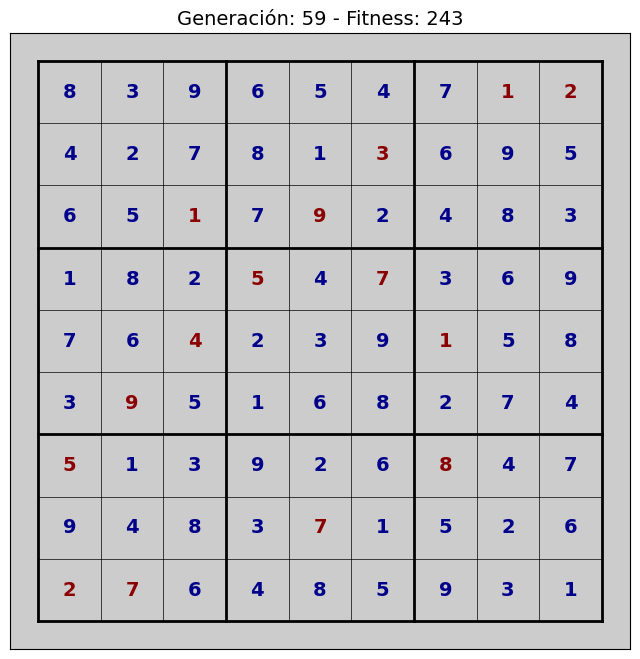

array([[8, 3, 9, 6, 5, 4, 7, 1, 2],
       [4, 2, 7, 8, 1, 3, 6, 9, 5],
       [6, 5, 1, 7, 9, 2, 4, 8, 3],
       [1, 8, 2, 5, 4, 7, 3, 6, 9],
       [7, 6, 4, 2, 3, 9, 1, 5, 8],
       [3, 9, 5, 1, 6, 8, 2, 7, 4],
       [5, 1, 3, 9, 2, 6, 8, 4, 7],
       [9, 4, 8, 3, 7, 1, 5, 2, 6],
       [2, 7, 6, 4, 8, 5, 9, 3, 1]])

In [14]:
sudoku_3 = [
    [0, 0, 0, 0, 0, 0, 0, 1, 2],
    [0, 0, 0, 0, 0, 3, 0, 0, 0],
    [0, 0, 1, 0, 9, 0, 0, 0, 0],
    [0, 0, 0, 5, 0, 7, 0, 0, 0],
    [0, 0, 4, 0, 0, 0, 1, 0, 0],
    [0, 9, 0, 0, 0, 0, 0, 0, 0],
    [5, 0, 0, 0, 0, 0, 8, 0, 0],
    [0, 0, 0, 0, 7, 0, 0, 0, 0],
    [2, 7, 0, 0, 0, 0, 0, 0, 0]
]
genetic = SudokuGeneticAlgorithm(
    pop_size=500, 
    max_generations=1000,
    mutation_rate=0.01,
    sudoku_puzzle=sudoku_3
)

genetic.start_genetic_algorithm()

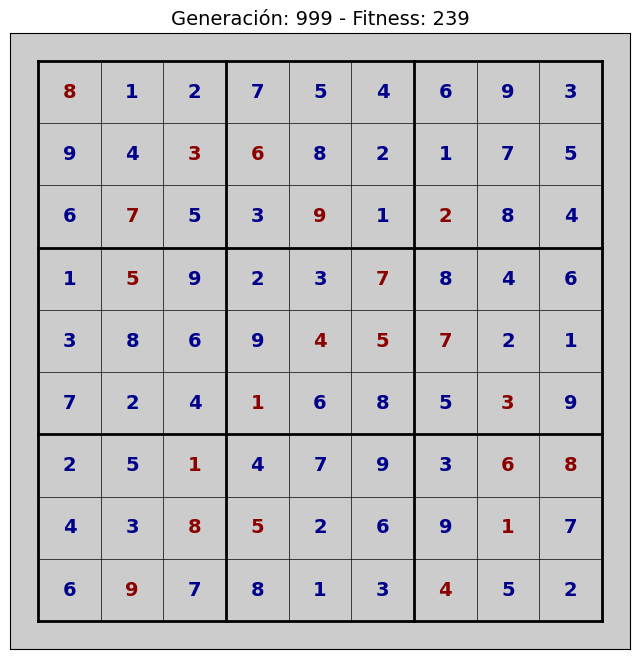

There is a problem in column: 1
The best solution found is not a perfectly valid Sudoku.


array([[8, 1, 2, 7, 5, 4, 6, 9, 3],
       [9, 4, 3, 6, 8, 2, 1, 7, 5],
       [6, 7, 5, 3, 9, 1, 2, 8, 4],
       [1, 5, 9, 2, 3, 7, 8, 4, 6],
       [3, 8, 6, 9, 4, 5, 7, 2, 1],
       [7, 2, 4, 1, 6, 8, 5, 3, 9],
       [2, 5, 1, 4, 7, 9, 3, 6, 8],
       [4, 3, 8, 5, 2, 6, 9, 1, 7],
       [6, 9, 7, 8, 1, 3, 4, 5, 2]])

In [15]:
sudoku_4 =[
    [8, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 6, 0, 0, 0, 0, 0],
    [0, 7, 0, 0, 9, 0, 2, 0, 0],
    [0, 5, 0, 0, 0, 7, 0, 0, 0],
    [0, 0, 0, 0, 4, 5, 7, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 3, 0],
    [0, 0, 1, 0, 0, 0, 0, 6, 8],
    [0, 0, 8, 5, 0, 0, 0, 1, 0],
    [0, 9, 0, 0, 0, 0, 4, 0, 0]
]

genetic = SudokuGeneticAlgorithm(
    pop_size=500, 
    max_generations=1000,
    mutation_rate=0.01,
    sudoku_puzzle=sudoku_4
)

genetic.start_genetic_algorithm()